In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as f
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchinfo import summary
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!nvidia-smi

Sat Aug  5 17:28:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     8W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class DatasetReader(Dataset):
    def __init__(self, filepath):
        self.X, self.y = torch.load(filepath)
        self.X = self.X/255.0
        self.y = f.one_hot(self.y, num_classes = 2).float()
    
    def __len__(self):
        return self.X.shape[0]
        
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

In [5]:
train_dir = "/kaggle/input/fire-detection-dataset/forest_fire/Training and Validation/"
test_dir = "/kaggle/input/fire-detection-dataset/forest_fire/Testing/"

In [6]:
train_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
     transforms.Normalize((0.5, 0.5, 0.5), 
                         (0.5, 0.5, 0.5)),
    transforms.Resize((120,120), antialias=True)
])

test_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
     transforms.Normalize((0.5, 0.5, 0.5), 
                         (0.5, 0.5, 0.5)),
    transforms.Resize((120,120,), antialias=True)
])

In [7]:
train_ds = datasets.ImageFolder(train_dir, transform = train_transform)
test_ds = datasets.ImageFolder(test_dir, transform = train_transform)

In [8]:
training_ds, validation_ds = random_split(train_ds,[0.7, 0.3])

In [9]:
batch_size = 32
training_ds = DataLoader(training_ds, batch_size = batch_size, shuffle = True)
validation_ds = DataLoader(validation_ds, batch_size = batch_size, shuffle = True)
testing_ds = DataLoader(test_ds, batch_size = 1, shuffle = True)

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3,100, (3, 3), stride = 1, padding = 1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(100),
                                    nn.MaxPool2d(kernel_size=(2, 2), stride = 1))
    
        self.layer2 = nn.Sequential(nn.Conv2d(100, 50, (3, 3), stride = 1, padding = 1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(50),
                                    nn.MaxPool2d(kernel_size=(2, 2), stride = 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(50*118*118, 50),
                                        nn.ReLU(),
                                        nn.Linear(50, 10),
                                        nn.ReLU(),
                                        nn.Linear(10, 2))
    def forward(self, X):
        
        X = self.layer1(X)
        X = self.layer2(X) 
        X = self.classifier(X)
        return X
        

In [11]:
model = NeuralNetwork().to(device)

In [12]:
summary(model)

Layer (type:depth-idx)                   Param #
NeuralNetwork                            --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       2,800
│    └─ReLU: 2-2                         --
│    └─BatchNorm2d: 2-3                  200
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-5                       45,050
│    └─ReLU: 2-6                         --
│    └─BatchNorm2d: 2-7                  100
│    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
│    └─Flatten: 2-9                      --
│    └─Linear: 2-10                      34,810,050
│    └─ReLU: 2-11                        --
│    └─Linear: 2-12                      510
│    └─ReLU: 2-13                        --
│    └─Linear: 2-14                      22
Total params: 34,858,732
Trainable params: 34,858,732
Non-trainable params: 0

In [13]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
def train_model(training_ds,model, device):
    
    """ The function performs use to train the model using training dataset
    and simulataneously use to validate the performance of the model in
    validation dataset. At the end it returns trained model for performing
    further inferencing.
    """
    
    model.train()
    num_epochs = 50
    for epoch in range(num_epochs):
        train_loss = 0
        correct_train_pred = 0
        for image, label in training_ds:
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(image)
            loss = loss_function(output, label)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            train_prediction = torch.argmax(output, axis=1)
            correct_train_pred += train_prediction.eq(label).sum().item() 
        
        model.eval()
        val_loss = 0
        correct_val_pred = 0
        batch_counter = 0
        with torch.no_grad():
            for image, label in validation_ds:
                image, label = image.to(device), label.to(device)
                val_output = model(image)
                val_loss += loss_function(val_output, label).item()
                _, prediction = val_output.max(1)
                batch_counter+=label.size(0)
                correct_val_pred+=prediction.eq(label).sum().item()
                
        avg_training_loss = train_loss / len(training_ds)
        train_accuracy = correct_train_pred/len(training_ds.dataset)
        avg_val_loss = val_loss / len(validation_ds)
        val_accuracy = correct_val_pred/ batch_counter
                
        print(f"Epoch: [{epoch+1}/{num_epochs}],  Train Loss: {avg_training_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}  ")
    return model

In [15]:
model = train_model(training_ds, model, device)

Epoch: [1/50],  Train Loss: 1.5168, Train Accuracy: 0.8535 Val Loss: 0.6704, Val Accuracy: 0.8689  
Epoch: [2/50],  Train Loss: 0.4034, Train Accuracy: 0.8332 Val Loss: 0.2212, Val Accuracy: 0.9290  
Epoch: [3/50],  Train Loss: 0.1658, Train Accuracy: 0.9369 Val Loss: 0.1855, Val Accuracy: 0.9417  
Epoch: [4/50],  Train Loss: 0.1303, Train Accuracy: 0.9486 Val Loss: 0.1558, Val Accuracy: 0.9454  
Epoch: [5/50],  Train Loss: 0.1212, Train Accuracy: 0.9571 Val Loss: 0.1616, Val Accuracy: 0.9399  
Epoch: [6/50],  Train Loss: 0.1037, Train Accuracy: 0.9595 Val Loss: 0.1890, Val Accuracy: 0.9362  
Epoch: [7/50],  Train Loss: 0.0837, Train Accuracy: 0.9712 Val Loss: 0.1710, Val Accuracy: 0.9545  
Epoch: [8/50],  Train Loss: 0.0647, Train Accuracy: 0.9735 Val Loss: 0.2009, Val Accuracy: 0.9454  
Epoch: [9/50],  Train Loss: 0.0549, Train Accuracy: 0.9797 Val Loss: 0.2090, Val Accuracy: 0.9472  
Epoch: [10/50],  Train Loss: 0.0427, Train Accuracy: 0.9860 Val Loss: 0.2147, Val Accuracy: 0.9472  

In [16]:
def test_ds_preidiction(model, testing_ds):
    """The function use to run our model in new test dataset and return
    two list that contain actual label and predicted label from the model
    """
    
    y_pred = []
    y_test = []
    with torch.no_grad():
        for image ,label in testing_ds:
            image, label = image.to(device), label.to(device)
            y_test.append(label.cpu().numpy())
            y_prediction = np.array(model(image).cpu().numpy()).argmax(axis = 1)
            y_pred.append(y_prediction)
        return y_test, y_pred

In [17]:
y_test, y_pred = test_ds_preidiction(model, testing_ds)
y_test = np.array(y_test).flatten()
y_pred = np.array(y_pred).flatten()

In [18]:
y_test

array([1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0])

In [19]:
y_pred

array([1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0])

In [20]:
print("Accuracy is ", accuracy_score(y_test, y_pred),"\n")
print("Precision is ", precision_score(y_test, y_pred),"\n")
print("Confusion is ", confusion_matrix(y_test, y_pred),"\n")

Accuracy is  0.9117647058823529 

Precision is  0.9761904761904762 

Confusion is  [[21  1]
 [ 5 41]] 



/tmp/ipykernel_25/212742391.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(resize_img, dtype=torch.float32) / 255.0


The image shows us  Fire


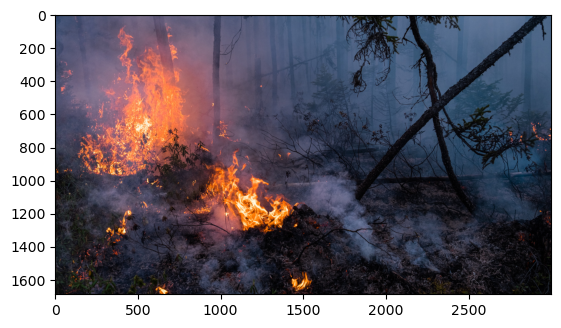

In [21]:
# torch.manaul_seed(42)
label = {0:"Fire",1: "No fire"}
img_path = "/kaggle/input/out-image/fire_imag.jpg"
img_array = plt.imread(img_path)
img_tensor = torch.tensor(img_array)
img = img_tensor.permute(2, 0, 1)
resize_img = transforms.Resize((120, 120), antialias=True)
resize_img = resize_img(img) 
img_tensor = torch.tensor(resize_img, dtype=torch.float32) / 255.0 
reshape_img = img_tensor.unsqueeze(0)
with torch.no_grad():
    output = model(reshape_img.to(device))
ouput = output.cpu().numpy().argmax(1)
print("The image shows us ", label[ouput[0]])
plt.imshow(img_array)
plt.show();
